# Energy Analytics Data Challenge [using R (ggplot2)]

## Business Use Case: Prediction of Energy Consumption of a Retail Store 

## Description

From the data set provided below, concerning the energy consumption of a retail store in 2014, we build a *timeseries model* to *predict* the **consumed energy (kWh)** made within a **specific time frame**. We provide both a *short-term (60 & 90 calendar days)* and a *long-term forecast (semester & one year prediction)*. The simulated time series of energy consumption which is returned by the model is surprisingly similar with the one provided, except some peaks during the hot summer days and the New Year's Eve. At these times the forecasted consumption is significantly lower than the one had during the same periods in 2014. Having historical data of two and more years would allow us to better incorporate these seasonalities in our model and hopefully provide even better predictions.

## Dataset

Dataset **`consumption.csv`** contains all signals of a **smart energy meter** that it is plugged in the store, along with information about **weather conditions** of the area and the **traffic of the store**, between dates `'2014-01-01'` and `'2014-12-31'`. 

The file is in comma separated format and contains the following variables:

* **`'signal_id'`:** unique id of every signal of the smart meter
* **`'kW'`:** the consumption that the signal transmits the given moment (have in mind: kWh = kW * h).
* **`'temperature'`:** the external temperature on the given moment in Celsius
* **`'traffic'`:** a category of the amount of traffic in the store the given moment (0: no traffic/closed - 4: peak)
* **`'timestamp'`:** the timestamp of the signal

## 1. Loading Libraries and User-defined Functions

In [1]:
# R LANG::
# Define where my R libraries reside
.libPaths('/home/theod/R/x86_64-redhat-linux-gnu-library/3.3')

# Load required libraries 
library('astsa')
library('mgcv')
library('dplyr')
library('zoo')
library('ggplot2')
library('grid')
library('reshape2')

# Globally set the ggplot2 theme options of preference
old_theme <- theme_get()
theme_set(theme_bw())
theme_update(plot.title=element_text(face='bold'))

Loading required package: nlme
This is mgcv 1.8-15. For overview type 'help("mgcv-package")'.

Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



## 2. Loading Consumption Data / Validity Checks

First, we load the consumption data set, **`'consumption.csv'`** from file. Note, that no **`'NA'`** values exists, or any other problems.

In [2]:
# R LANG::
# Load the data set
consumpt_df <- read.csv('./../../07.JobApps/Intelen-data_challenge/02.consumption.csv')
consumpt_df$timestamp <- as.POSIXct(consumpt_df$timestamp, '%Y-%m-%d %H:%M:%S')

In [3]:
# R LANG::
head(consumpt_df)

signal_id,timestamp,kw,temperature,traffic
1,2014-01-01 00:00:00,17.625,1,closed
2,2014-01-01 01:00:00,17.675,1,closed
3,2014-01-01 02:00:00,17.775,0,closed
4,2014-01-01 03:00:00,17.750,0,closed
5,2014-01-01 04:00:00,17.750,0,closed
6,2014-01-01 05:00:00,17.700,0,closed


In [4]:
# R LANG::
# DataFrame structure
str(consumpt_df)

'data.frame':	8760 obs. of  5 variables:
 $ signal_id  : int  1 2 3 4 5 6 7 8 9 10 ...
 $ timestamp  : POSIXct, format: "2014-01-01 00:00:00" "2014-01-01 01:00:00" ...
 $ kw         : num  17.6 17.7 17.8 17.8 17.8 ...
 $ temperature: num  1 1 0 0 0 0 0 0 -1 3 ...
 $ traffic    : Factor w/ 5 levels "closed","high",..: 1 1 1 1 1 1 1 1 1 3 ...


In [5]:
# R LANG::
summary(consumpt_df)

   signal_id      timestamp                         kw          temperature   
 Min.   :   1   Min.   :2014-01-01 00:00:00   Min.   :  0.00   Min.   :-5.00  
 1st Qu.:2191   1st Qu.:2014-04-02 05:45:00   1st Qu.:  8.60   1st Qu.: 8.00  
 Median :4380   Median :2014-07-02 11:30:00   Median : 17.45   Median :14.00  
 Mean   :4380   Mean   :2014-07-02 11:30:00   Mean   : 26.56   Mean   :14.09  
 3rd Qu.:6570   3rd Qu.:2014-10-01 17:15:00   3rd Qu.: 36.25   3rd Qu.:19.00  
 Max.   :8760   Max.   :2014-12-31 23:00:00   Max.   :143.62   Max.   :34.00  
       traffic    
 closed    :4432  
 high      :1514  
 low       : 991  
 medium    :1511  
 super high: 312  
                  

### A. Uniqueness of **`'signal_id'`** & **`'timestamp'`** as a surrogate table key [no duplicated records]

In [6]:
# R LANG::
# Check the uniqueness of key in data set
num_unique_values = length(unique(consumpt_df$signal_id))
num_records = length(consumpt_df$signal_id)
is_key = (num_unique_values == num_records)
paste('Checks the uniqueness of "signal_id" [key]:', is_key)

[1] "Checks the uniqueness of \"signal_id\" [key]: TRUE"

In [7]:
# R LANG::
# Check the uniqueness of key in data set
num_unique_values = length(unique(consumpt_df$timestamp))
num_records = length(consumpt_df$timestamp)
is_key = (num_unique_values == num_records)
paste('Checks the uniqueness of "timestamp" [key]:', is_key)

[1] "Checks the uniqueness of \"timestamp\" [key]: TRUE"

### B. Validity of **`'timestamp'`**

The **`'timestamp'`** values includes signals from the whole 2014, i.e. from **`'2014-01-01'`** to **`'2014-12-31'`**, as described in the problem task.

In [8]:
# R LANG::
summary(consumpt_df$timestamp)

                 Min.               1st Qu.                Median 
"2014-01-01 00:00:00" "2014-04-02 05:45:00" "2014-07-02 11:30:00" 
                 Mean               3rd Qu.                  Max. 
"2014-07-02 11:30:00" "2014-10-01 17:15:00" "2014-12-31 23:00:00" 

### C. Categorical attributes [`'traffic'`]

In [9]:
# R LANG::
str(consumpt_df$traffic)

 Factor w/ 5 levels "closed","high",..: 1 1 1 1 1 1 1 1 1 3 ...


In [10]:
# R LANG::
summary(consumpt_df$traffic)

closed       high        low     medium super high 
      4432       1514        991       1511        312

### D. Float attributes [`'kw'`, `'tempreture'`]

In [11]:
# R LANG::
summary(consumpt_df$kw)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.60   17.45   26.56   36.25  143.60 

In [12]:
# R LANG::
summary(consumpt_df$temperature)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -5.00    8.00   14.00   14.09   19.00   34.00 

## 3. Timeseries Data Analysis: Recognizing possible models to fit

First, we create a new attribute **(`'kWh'`)** in the **`'consumpt_df'` DataFrame**, to accomodate the **Energy Consumption** made by the **retail store**. Since the provided data set has been sampled every single hour, this new **`'kWh'`** attribute will be equal-valued with the provided **`'kw'`** one. We also change the **colname `'temperature'`** to something sorter for our convenience.

In [13]:
# R LANG::
head(consumpt_df, n=10)

signal_id,timestamp,kw,temperature,traffic
1,2014-01-01 00:00:00,17.625,1,closed
2,2014-01-01 01:00:00,17.675,1,closed
3,2014-01-01 02:00:00,17.775,0,closed
4,2014-01-01 03:00:00,17.750,0,closed
5,2014-01-01 04:00:00,17.750,0,closed
6,2014-01-01 05:00:00,17.700,0,closed
7,2014-01-01 06:00:00,17.650,0,closed
8,2014-01-01 07:00:00,17.700,0,closed
9,2014-01-01 08:00:00,17.725,-1,closed
10,2014-01-01 09:00:00,17.675,3,low


In [14]:
# R LANG::
consumpt_df$kWh = consumpt_df$kw
names(consumpt_df)[4] <- 'Temp'
names(consumpt_df)[5] <- 'Traffic'
head(consumpt_df)

signal_id,timestamp,kw,Temp,Traffic,kWh
1,2014-01-01 00:00:00,17.625,1,closed,17.625
2,2014-01-01 01:00:00,17.675,1,closed,17.675
3,2014-01-01 02:00:00,17.775,0,closed,17.775
4,2014-01-01 03:00:00,17.750,0,closed,17.750
5,2014-01-01 04:00:00,17.750,0,closed,17.750
6,2014-01-01 05:00:00,17.700,0,closed,17.700


### A. Exploratory Data Analysis

It is important to note, that the recorded **energy consumption** is depended on the **traffic of the store (`Traffic='closed'/'low'/'medium'/'high'/'super high'`)** and the **external weather conditions (temperature,`Temp`)**, as expected.

`geom_smooth()` using method = 'gam'


null device 
          1

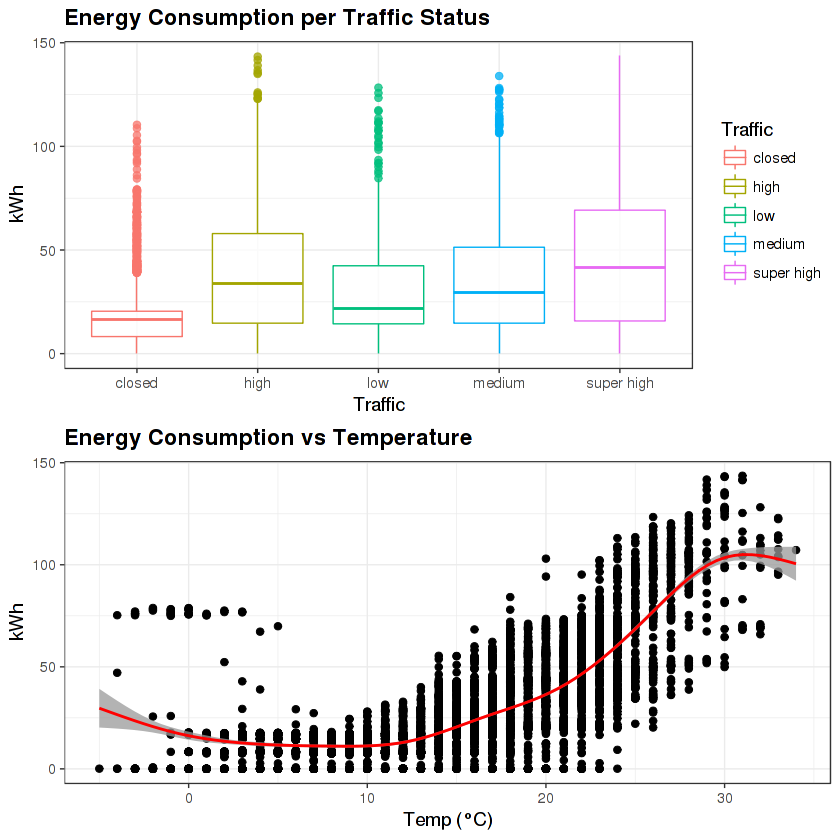

In [15]:
# R LANG::
grid.newpage()
pushViewport(viewport(layout = grid.layout(2,1)))
# "Energy consumption" vs "Retail Store Traffic"
f1 <- (ggplot(consumpt_df) +
           geom_boxplot(aes(Traffic, kWh, colour=Traffic), alpha=0.75) +
           labs(title='Energy Consumption per Traffic Status', xlab='Retail Store Traffic', ylab='kWh'))
# "Energy Consumption" vs "Temperature"
f2 <- (ggplot(consumpt_df) + 
           geom_point(aes(Temp, kWh)) + 
           geom_smooth(aes(Temp,kWh), colour='red', alpha=0.75) + 
           labs(title='Energy Consumption vs Temperature', x='Temp (\u00b0C)', y='kWh'))
# Print the plots in the pre-defined Viewport
print(f1, vp=viewport(layout.pos.row = 1, layout.pos.col = 1))
print(f2, vp=viewport(layout.pos.row = 2, layout.pos.col = 1))
dev.off()

By resampling the **Energy Consumption Timeseries** on a **Daily Basis**, we can have a better understanding of its time evolution and its dependence / correlation with the corresponding **Temperature Timeseries**. The **rolling moving averages** in 5 and in 30 calendar days, **`MA5`** and **`MA30`**, are also depicted for both series. Note that the standard deviation of the **`'kWh'`** series greatly varies taking values from `0` to `~750 kWh` and appears peak during the hot summer months.

In [16]:
head(consumpt_df)

signal_id,timestamp,kw,Temp,Traffic,kWh
1,2014-01-01 00:00:00,17.625,1,closed,17.625
2,2014-01-01 01:00:00,17.675,1,closed,17.675
3,2014-01-01 02:00:00,17.775,0,closed,17.775
4,2014-01-01 03:00:00,17.750,0,closed,17.750
5,2014-01-01 04:00:00,17.750,0,closed,17.750
6,2014-01-01 05:00:00,17.700,0,closed,17.700


In [17]:
# R LANG::
# Create the time series of interest:
# (1) Energy Consumption TimeSeries ["KWh"]
kWh <- ts(consumpt_df$kWh,
          start = c(2014,1),
          end = c(2014,nrow(consumpt_df)),
          frequency=24*365)

# (2) External Temperature TimeSeries ["Temp"]
Temp <- ts(consumpt_df$Temp,
           start=c(2014,1),
           end=c(2014,nrow(consumpt_df)),
           frequency=24*365)

# (3) Traffic Status TimeSeries ["Traffic"]
consumpt_df['Date'] <- as.Date(consumpt_df$timestamp)

TrafficFreq <- (consumpt_df %>%
                    group_by(Date, Traffic) %>%
                    count(Traffic) %>%
                    filter(Traffic != 'closed') %>%
                    filter(n==max(n)) %>%
                    filter(as.integer(Traffic)==max(as.integer(Traffic))))

rTraffic <- ts(TrafficFreq$Traffic,
               start = c(2014,1),
               end = c(2014,nrow(TrafficFreq)),
               frequency=365)

# R LANG::
# Energy Consumption & Temperature TimeSeries plots
par(mfrow=c(2,1))
# Resample TimeSeries of interest on a Daily Basis
rkWh <- aggregate(kWh, nfrequency = 365, FUN = sum)
rTemp <- aggregate(Temp, nfrequency = 365, FUN = mean)
# Cbind the TimeSeries of interest in a DataFrame
ragg <- data.frame(cbind(date=index(rkWh), 
                         rkwh=melt(rkWh)$value, 
                         rkwh_ma5=melt(rollmean(rkWh,5))$value, 
                         rkwh_ma30=melt(rollmean(rkWh,30))$value,
                         rkwh_std5=melt(rollapply(data=rkWh, width=5, FUN=sd, fill=NA))$value,
                         rtemp=melt(rTemp)$value,
                         rtemp_ma5=melt(rollmean(rTemp,5))$value,
                         rtemp_ma30=melt(rollmean(rTemp,30))$value))

Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 29 rows containing missing values (geom_path).”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 29 rows containing missing values (geom_path).”

null device 
          1

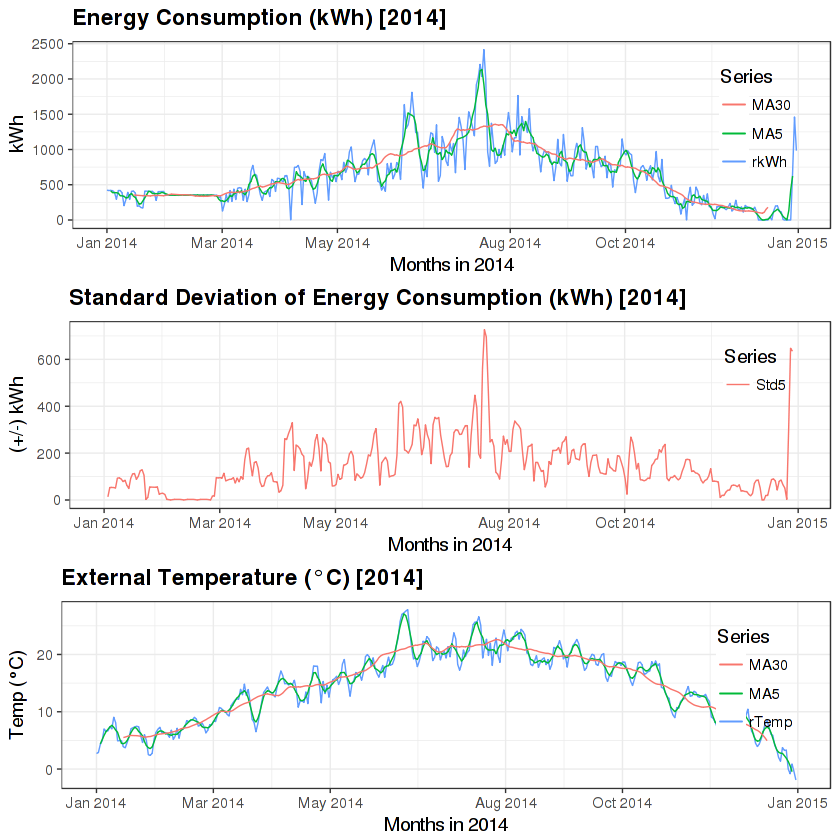

In [18]:
# R LANG:: [ggplot2+]
# Energy Consumption & Temperature TimeSeries plots
grid.newpage()
pushViewport(viewport(layout = grid.layout(3,1, widths=unit(1,'npc'), heights=unit(1/3,'npc'))))

fig1 <- (ggplot(ragg, aes(date)) +
             geom_line(aes(y=rkwh, colour='rkWh')) + 
             geom_line(aes(y=rkwh_ma5, colour='MA5')) +
             geom_line(aes(y=rkwh_ma30, colour='MA30')) +         
             theme(legend.position = c(0.9,0.9), legend.justification=c(0.5, 1),
                   legend.background = element_blank()) +
             labs(title='Energy Consumption (kWh) [2014]', x='Months in 2014', y='kWh', 
                  colour='Series') +
             scale_x_yearmon())

fig2 <- (ggplot(ragg, aes(date)) + #, width=14, height=6, units='cm') +
             geom_line(aes(y=rkwh_std5, colour='Std5')) +
             theme(legend.position = c(0.9,0.9), legend.justification = c(0.5,1), 
                   legend.background = element_blank()) +
             labs(title='Standard Deviation of Energy Consumption (kWh) [2014]', x='Months in 2014', y='(+/-) kWh',
                  colour='Series') +
             scale_x_yearmon())

fig3 <- (ggplot(ragg, aes(date)) + #, width=14, height=6, units='cm') +
             geom_line(aes(y=rtemp, colour='rTemp')) + 
             geom_line(aes(y=rtemp_ma5, colour='MA5')) +
             geom_line(aes(y=rtemp_ma30, colour='MA30')) +
             theme(legend.position = c(0.9,0.9), legend.justification=c(0.5, 1),
                   legend.background = element_blank()) +
             labs(title='External Temperature (\u00b0C) [2014]', x='Months in 2014', y='Temp (\u00b0C)',
                  colour='Series') +
             scale_x_yearmon())

# Print the plots in the pre-defined Viewport
print(fig1, vp=viewport(layout.pos.row = 1, layout.pos.col = 1))
print(fig2, vp=viewport(layout.pos.row = 2, layout.pos.col = 1))
print(fig3, vp=viewport(layout.pos.row = 3, layout.pos.col = 1))
dev.off()

### B. `'kWh'` Timeseries: Univariate analysis and autoregression model adequacy

As a next step, we try to figure out if we can study the **Energy Consumption Timeseries (`'kWh'`)** alone, and if some autorgression model will be adequate enough to provide predictions.

As shown below, there is no easy way to figure out the autoregression model that might fit the data well. The **Energy Consumption Timeseries (`'kWh'`)** appears to have huge variability, especially during the summer months, and there is no easy way to absorb it through a suitable transformation. Even if we detrend the provided timeseries, the results we obtain are not great.

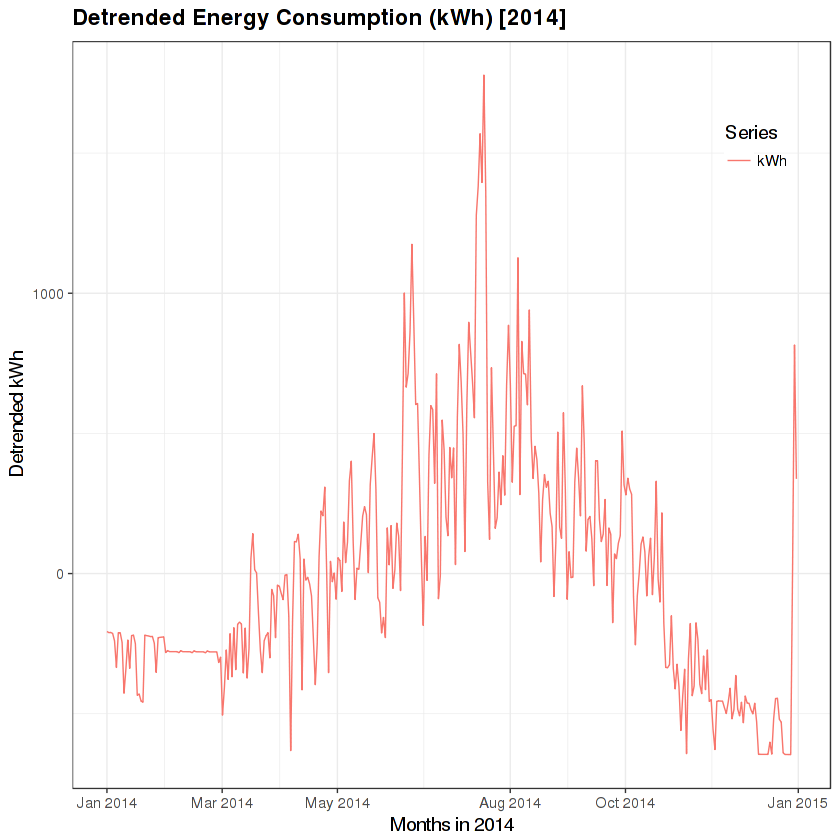

In [19]:
# R LANG::
fit <- lm(rkWh ~ time(rkWh), na.action = NULL)
rkWh2 <-resid(fit) # Detrended rkWh
tempDF <- data.frame(cbind(date=index(rkWh2),
                           rkwh2=melt(rkWh2)$value))

fig <- (ggplot(tempDF, aes(date)) + 
            geom_line(aes(y=rkwh2, colour='kWh')) +
            theme(legend.position = c(0.9,0.9), legend.justification = c(0.5,1),
                  legend.background = element_blank()) + 
            labs(title='Detrended Energy Consumption (kWh) [2014]', x='Months in 2014', y='Detrended kWh',
                 colour='Series') +
            scale_x_yearmon())
            
print(fig)

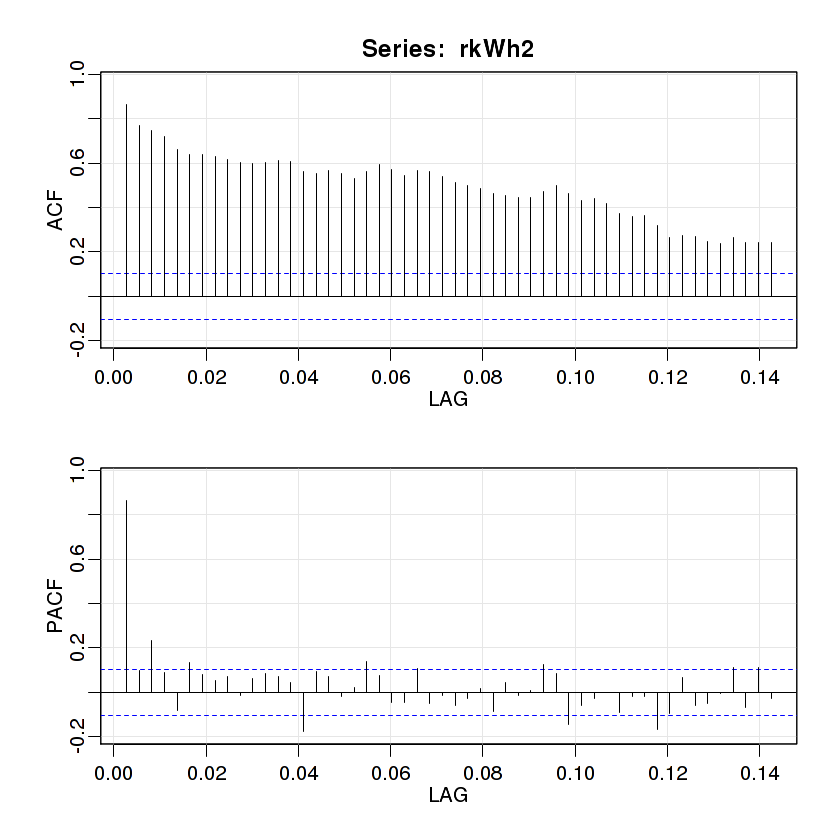

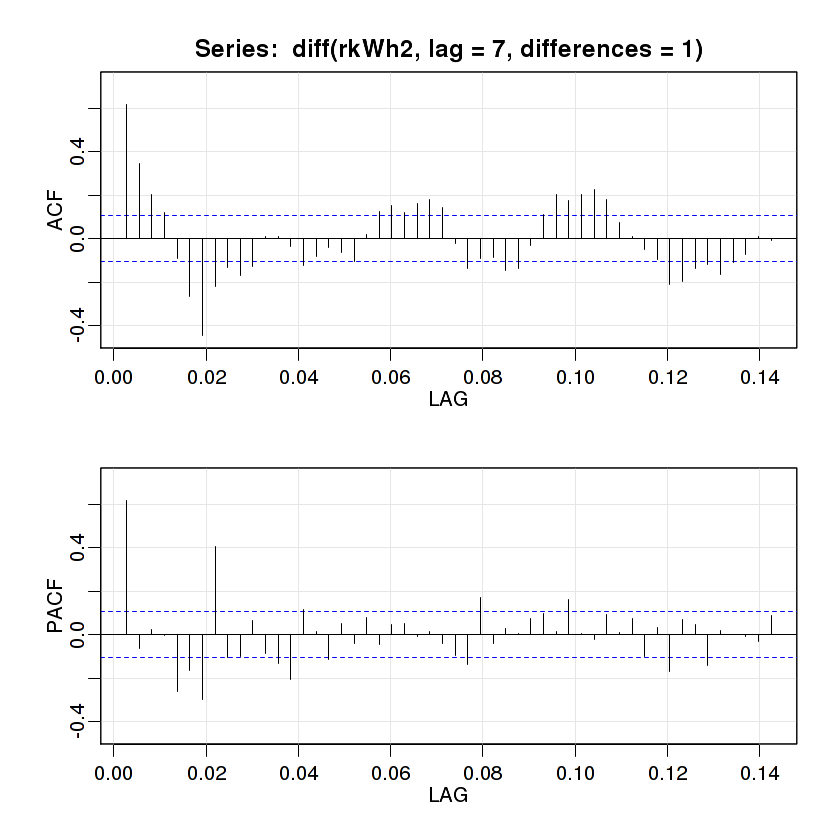

In [20]:
# R LANG::
# ACF/PACF Plots
acf <- acf2(rkWh2, max.lag=52) # Suggests diff(x, lag=5, differences=1)
acf <- acf2(diff(rkWh2, lag=7, differences = 1), max.lag=52) # Suggests ???
#acf <- acf2(diff(diff(rkWh2, lag=7, differences = 1)), max.lag=52) # Suggests ???

## 4. Model Fitting: utilizing the `'kWh'` ~ `'Temp'` & `'Traffic'` dependence

As stated in the part 3 of this analysis the correlation between the **`'kWh'`** and **`'Temp'`** timeseries is apparent, whereas a quadratic dependence of **"kWh"** from the corresponding **"Temp" values** is more appropriate to consider. In addition, the **energy consumption** obviously depends on the **traffic status** of the store but probably not strongly.

In order to incorporate these dependences in our model, we are going to fit a regression model with autocorrelated errors. To do so we will follow an algorithm which has been introduced by Cochrane and Orcutt (1949), and it is described in the ["Time Series Analysis and Its Applications: With R Examples" (Springer Texts in Statistics), by R. H. Shumway and D. S. Stoffer](http://www.springer.com/us/book/9783319524511). 

More specificaly, assuming the regression model below:

$$
y_{t} = \mathbf{\beta}\mathbf{z_{t}} + x_{t}
$$

where $\mathbf{\beta}$ is an $r\times 1$ vector of regression parameters, $\mathbf{z_{t}}$ an $r\times 1$ vector of regressors (exogeneous variables), and $x_{t}$ a process with some covariance function $\gamma(s,t)$ we will:

1. Run an ordinary regression fit of $y_{t}$ **(`"KWh"`)** on $x_{t}$ **(`"Temp"`)** (acting as if the errors are uncorrelated), and retain the residuals.

2. Fit an ARMA Model to the residuals $\widehat{x_{t}}=y_{t}-\widehat{\mathbf{\beta}}\mathbf{z_{t}}$, say
$$
\widehat{\phi}(B)\widehat{x_{t}} = \widehat{\theta}(B)w_{t}
$$

3. Apply the ARMA transformation to both sides of the initial model in order to obtain the transformed regression one.
$$
u_{t} = \frac{\widehat{\phi}(B)}{\widehat{\theta}(B)}y_{t}\quad\text{and}\quad \mathbf{v_{t}}=\frac{\widehat{\phi}(B)}{\widehat{\theta}(B)}\mathbf{z_{t}}
$$

4. Run an ordinary least squares regression assuming uncorrelated errors on the transformed regression model
$$
u_{t} = \mathbf{\beta}\mathbf{v_{t}} + w_{t}\,,
$$
where $w_{t}$ is expected now to be... white noise!

### Choose the best Odinary Regression Model to fit: 

In [21]:
# R LANG::
# Regression Models To Better Investigate
rkwh_trend <- time(rkWh)
rtemp_demean <- rTemp - mean(rTemp)
rtemp_demeanSq <- rtemp_demean^2
rtemp_demeanCb <- rtemp_demean^3
fit1 <- lm(rkWh ~ rkwh_trend + rtemp_demean, na.action=NULL)
fitSq1 <- lm(rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq , na.action=NULL)
fitCb1 <- lm(rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq + rtemp_demeanCb, na.action=NULL)
fit2 <- lm(rkWh ~  rkwh_trend + rtemp_demean + rTraffic, na.action=NULL)
fitSq2 <- lm(rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq + rTraffic, na.action=NULL)
fitCb2 <- lm(rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq + rtemp_demeanCb + rTraffic, na.action=NULL)
fitLoess1 <- loess(rkWh ~ rkwh_trend + rtemp_demean, model=TRUE)
fitGam1 <- gam((rkWh ~ s(rtemp_demean, bs='gp')
                + ti(rkwh_trend, rtemp_demean, by=rTraffic, bs='gp')))
fitGam2 <- gam((rkWh ~ rTraffic +  s(rtemp_demean, bs='gp')
                + ti(rkwh_trend, rtemp_demean, by=rTraffic, bs='gp')))

# R LANG::
# ANOVA Results & Statistics Information Criteria

# Regression Models Summary
models <- list(fit1, fitSq1, fitCb1, fit2, fitSq2, fitCb2, fitLoess1, fitGam1, fitGam2)
modelnames <- list('fit1', 'fitSq1', 'fitCb1', 'fit2', 'fitSq2', 'fitCb2', 'fitLoess1', 'fitGam1', 'fitGam2')

writeLines('Analysis of Variance & Statistics Information Criteria:\n')
for(i in seq(1,length(models))) {
    s = paste0('Model ', modelnames[[i]], ':')
    writeLines(s)
    writeLines(paste0(strrep('-', nchar(s) + 3), '\n'))
    print(summary(models[[i]]))
    writeLines('\n')
    }

# ANOVA Results
print(anova(fit1,fitSq1,fitCb1,fit2,fitSq2,fitCb2,fitGam1,fitGam2))

# Statistics Information Criteria
df <- AIC(fit1,fitSq1,fitCb1,fit2,fitSq2,fitCb2,fitGam1,fitGam2)
df[order(df$AIC),]

df <- BIC(fit1,fitSq1,fitCb1,fit2,fitSq2,fitCb2,fitGam1,fitGam2)
df[order(df$BIC),]

Analysis of Variance & Statistics Information Criteria:

Model fit1:
--------------


Call:
lm(formula = rkWh ~ rkwh_trend + rtemp_demean, na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-800.40 -139.63  -14.63   85.53 1714.47 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  388683.873  92584.085   4.198 3.39e-05 ***
rkwh_trend     -192.627     45.959  -4.191 3.49e-05 ***
rtemp_demean     54.659      2.099  26.044  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 249.6 on 362 degrees of freedom
Multiple R-squared:  0.6521,	Adjusted R-squared:  0.6501 
F-statistic: 339.2 on 2 and 362 DF,  p-value: < 2.2e-16



Model fitSq1:
----------------


Call:
lm(formula = rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq, 
    na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-683.72 -100.53    5.72   83.95 1138.79 

Coefficients:
                 Estimate Std. Er

,df,AIC
fitGam1,15.81065,4859.555
fitGam2,16.61954,4860.155
fitCb1,6.00000,4867.337
fitCb2,7.00000,4868.344
fitSq1,5.00000,4877.797
fitSq2,6.00000,4878.874
fit1,4.00000,5070.215
fit2,5.00000,5071.542


,df,BIC
fitCb1,6.00000,4890.736
fitCb2,7.00000,4895.643
fitSq1,5.00000,4897.296
fitSq2,6.00000,4902.273
fitGam1,15.81065,4921.215
fitGam2,16.61954,4924.970
fit1,4.00000,5085.815
fit2,5.00000,5091.041


In [22]:
summary(fitGam1)


Family: gaussian 
Link function: identity 

Formula:
rkWh ~ s(rtemp_demean, bs = "gp") + ti(rkwh_trend, rtemp_demean, 
    by = rTraffic, bs = "gp")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   638.21      18.15   35.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                       edf Ref.df       F  p-value    
s(rtemp_demean)                      8.007  8.759 105.544  < 2e-16 ***
ti(rkwh_trend,rtemp_demean):rTraffic 5.804  6.837   7.937 4.93e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.81   Deviance explained = 81.7%
GCV =  35319  Scale est. = 33886     n = 365

In [23]:
summary(fitSq1)


Call:
lm(formula = rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq, 
    na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-683.72 -100.53    5.72   83.95 1138.79 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     4.556e+05  7.116e+04   6.402 4.76e-10 ***
rkwh_trend     -2.259e+02  3.532e+01  -6.395 4.96e-10 ***
rtemp_demean    5.895e+01  1.633e+00  36.109  < 2e-16 ***
rtemp_demeanSq  3.811e+00  2.391e-01  15.936  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 191.5 on 361 degrees of freedom
Multiple R-squared:  0.7957,	Adjusted R-squared:  0.794 
F-statistic: 468.8 on 3 and 361 DF,  p-value: < 2.2e-16


From the **ANOVA results** shown above, the **statistics information criteria (`AIC`, `BIC`)**, and the **variance explained** by each of the models, we choose the  **`fitGam1`** model as the one that fits our data best, with the more simpler ones, **`fitCb1`** and **`fitSq1`**, coming immediately after. Due to the relatively small data size, we have assumed that the **`AIC`** results are more reliable for our problem. An important advantage of the **`fitGam1`** model over the other two, is that incorporate nicely the energy consumption dependence on the external temperature and on the traffic in store through appropriately configured interactions, i.e. the
```
rkWh ~ s(rtemp_demean, bs = "gp") + ti(rkwh_trend, rtemp_demean, by = rTraffic, bs = "gp"),
```
explains 81.7% of deviance in the provided data, and as we will show below, it provides residuals which can be predicted by an appropriate autoregression model extremely well! On the contrary, the residuals of the **`fitCb1`** model are not very helpful to figure out an appropriate autoregression model to fit. Consequently, we will choose only the **`fitGam1`** and **`fitSq1`** models to further investigate.

### Fit a suitable SARIMA Model: 

#### ACF / PACF Plots and preliminary list of models to fit.

#### A. `fitGam1`


Family: gaussian 
Link function: identity 

Formula:
rkWh ~ s(rtemp_demean, bs = "gp") + ti(rkwh_trend, rtemp_demean, 
    by = rTraffic, bs = "gp")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   638.21      18.15   35.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                       edf Ref.df       F  p-value    
s(rtemp_demean)                      8.007  8.759 105.544  < 2e-16 ***
ti(rkwh_trend,rtemp_demean):rTraffic 5.804  6.837   7.937 4.93e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.81   Deviance explained = 81.7%
GCV =  35319  Scale est. = 33886     n = 365

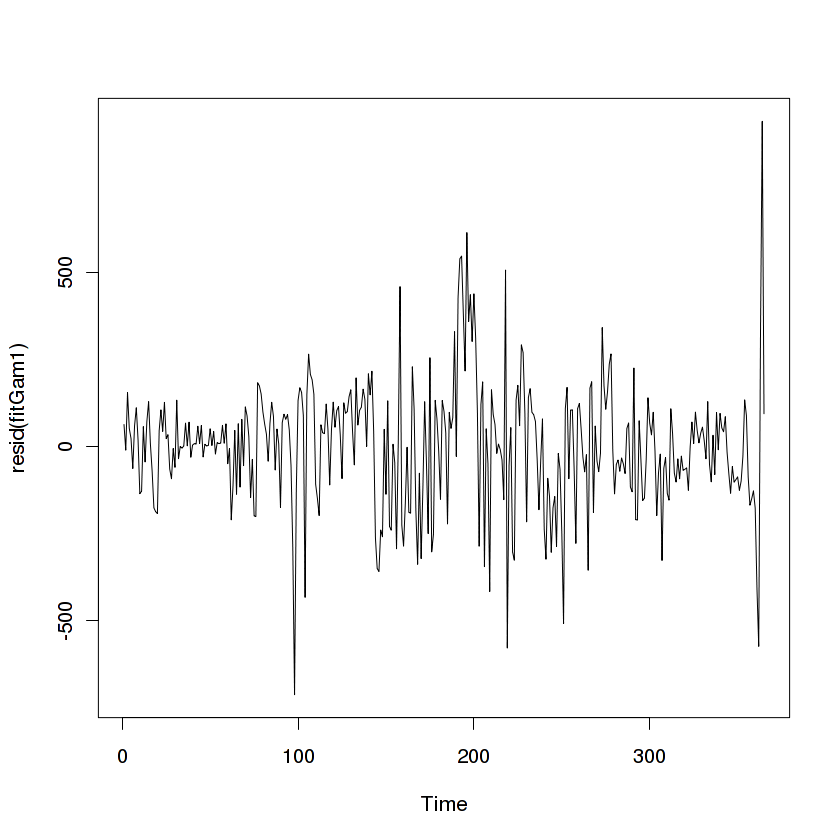

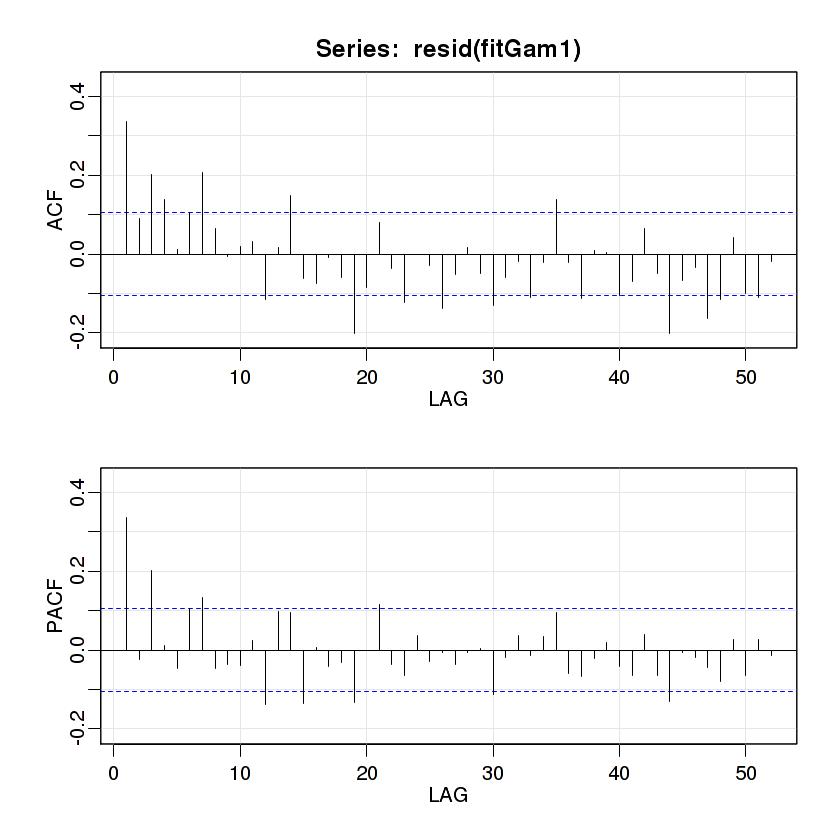

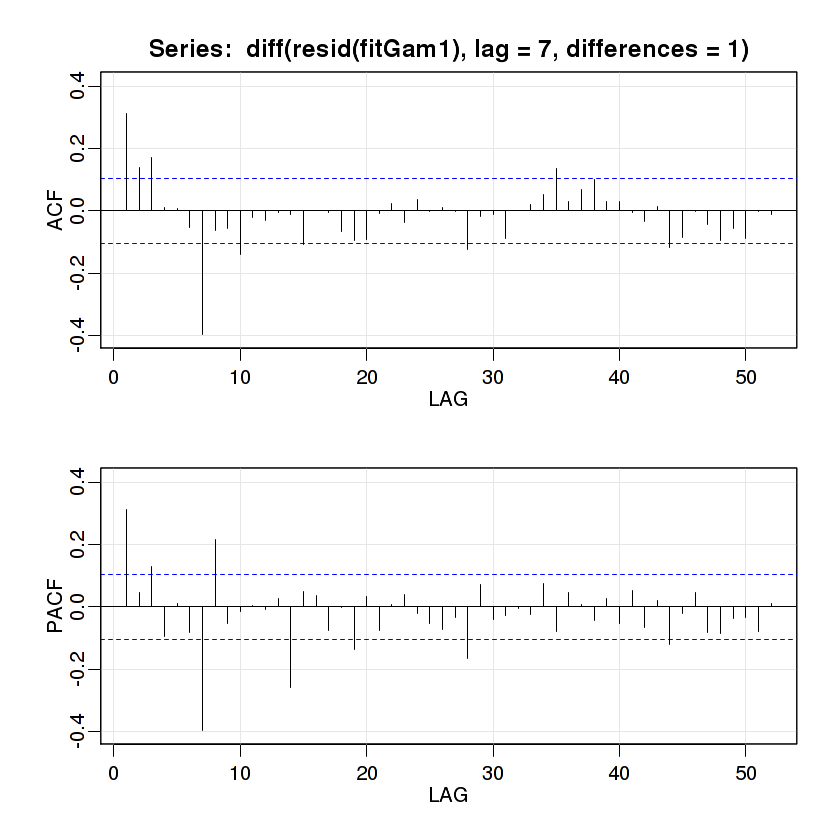

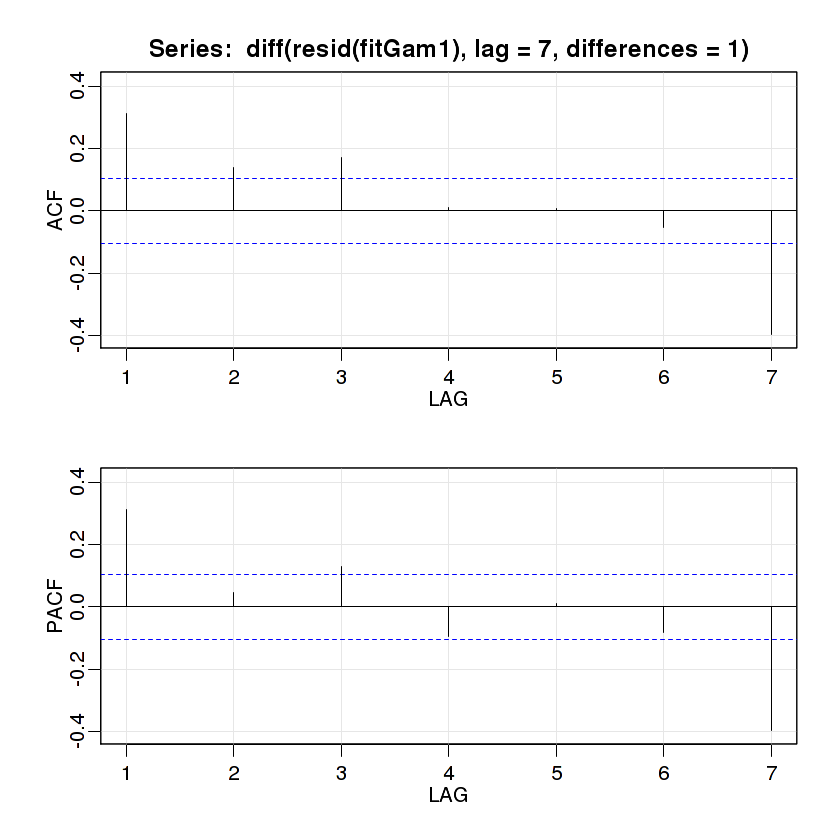

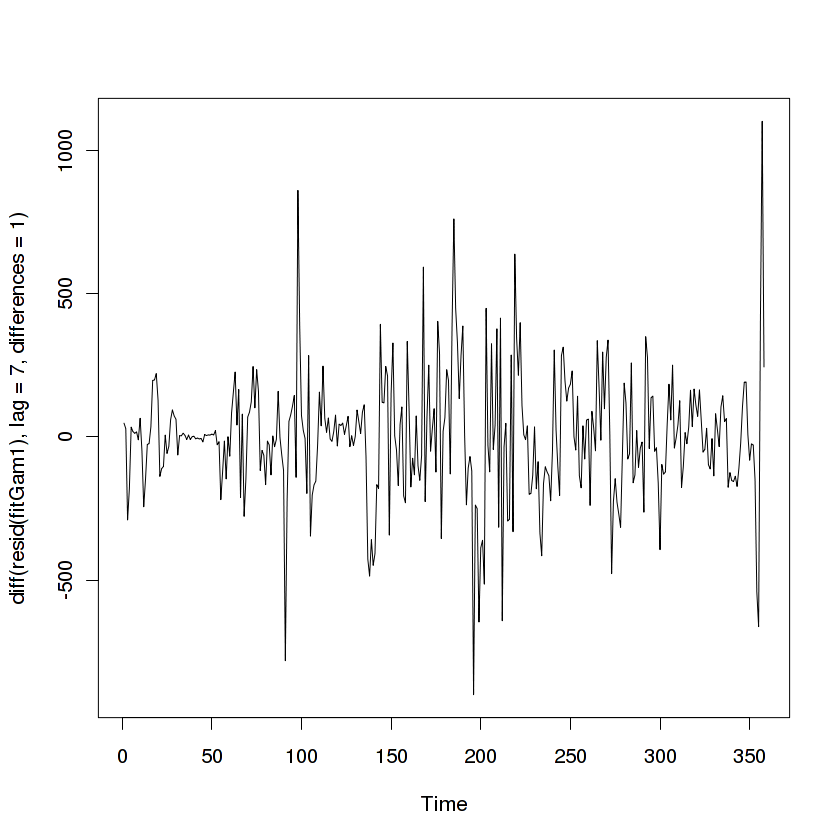

In [24]:
# R LANG::
summary(fitGam1)
plot.ts(resid(fitGam1))
acf <- acf2(resid(fitGam1), max.lag = 52) # Suggests  diff(x,lag=7, differences=1)
acf <- acf2(diff(resid(fitGam1), lag=7, differences = 1), max.lag = 52) # Suggests [ARMA(?,?) x ARMA(0,2)_{7}]
acf <- acf2(diff(resid(fitGam1), lag=7, differences = 1), max.lag = 7) # Suggests [ARMA(1,3(0)) x ARMA(0,2)_{7}]
plot.ts(diff(resid(fitGam1), lag=7, differences = 1))

#### ARIMA Models to Investigate/Fit:  

#### $\mathbf{ARIMA(1,0,3)\,\times\,(0,1,2)_{7}}$  and slight variations in the non-seasonal `AR` and `MA` orders

The previous **ACF/PACF plots** suggest that an $\mathbf{ARIMA(1,0,3)\,\times\,(0,1,2)_{7}}$ model will provide a really good fit to our data, probably with some variations in the non-seasonal **AR** and **MA** orders. 

In the few lines of code below we examine this fit, the results we obtain from the **`'arima'` R routine**, as well as slight variations of this model which are suggested by the t-Statistics of its calculated coefficients. We conclude that the $\mathbf{ARIMA(1,0,2)\,\times\,(0,1,1)_{7}}$ model, **`fitSq1_SARIMA2`**, fits our data best. Note that the design matrix which was used during the fitting of the **`fitSq1`** model, 
```
XReg <- fitGam1$linear.predictors,
```
has been plugged-in as a **matrix of external regressors (exogenous variables)**, in the new **ARIMA fits**.


Family: gaussian 
Link function: identity 

Formula:
rkWh ~ s(rtemp_demean, bs = "gp") + ti(rkwh_trend, rtemp_demean, 
    by = rTraffic, bs = "gp")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   638.21      18.15   35.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                       edf Ref.df       F  p-value    
s(rtemp_demean)                      8.007  8.759 105.544  < 2e-16 ***
ti(rkwh_trend,rtemp_demean):rTraffic 5.804  6.837   7.937 4.93e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.81   Deviance explained = 81.7%
GCV =  35319  Scale est. = 33886     n = 365

initial  value 5.390380 
iter   2 value 5.230578
iter   3 value 5.097274
iter   4 value 5.089144
iter   5 value 5.086302
iter   6 value 5.084543
iter   7 value 5.083379
iter   8 value 5.082976
iter   9 value 5.082522
iter  10 value 5.082219
iter  11 value 5.081746
iter  12 value 5.080399
iter  13 value 5.078866
iter  14 value 5.077693
iter  15 value 5.076754
iter  16 value 5.076238
iter  17 value 5.076148
iter  18 value 5.076101
iter  19 value 5.076099
iter  20 value 5.076049
iter  21 value 5.076042
iter  22 value 5.076038
iter  23 value 5.076034
iter  24 value 5.076029
iter  25 value 5.076025
iter  26 value 5.076023
iter  27 value 5.076023
iter  27 value 5.076023
iter  27 value 5.076023
final  value 5.076023 
converged
initial  value 5.087791 
iter   2 value 5.087442
iter   3 value 5.087341
iter   4 value 5.087328
iter   5 value 5.087300
iter   6 value 5.087293
iter   7 value 5.087287
iter   8 value 5.087272
iter   9 value 5.087254
iter  10 value 5.087235
iter  11 value 5.087229
iter 

$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = xreg, optim.control = list(trace = trc, REPORT = 1, 
    reltol = tol))

Coefficients:
         ar1      ma1      ma2     ma3     sma1     sma2    xreg
      0.8136  -0.4417  -0.1654  0.0673  -0.9021  -0.0024  0.9171
s.e.  0.1161   0.1212   0.0767  0.0616   0.0603   0.0628  0.0524

sigma^2 estimated as 25379:  log likelihood = -2329.21,  aic = 4674.41

$degrees_of_freedom
[1] 358

$ttable
     Estimate     SE  t.value p.value
ar1    0.8136 0.1161   7.0059  0.0000
ma1   -0.4417 0.1212  -3.6426  0.0003
ma2   -0.1654 0.0767  -2.1553  0.0318
ma3    0.0673 0.0616   1.0922  0.2755
sma1  -0.9021 0.0603 -14.9631  0.0000
sma2  -0.0024 0.0628  -0.0380  0.9697
xreg   0.9171 0.0524  17.5097  0.0000

$AIC
[1] 11.18002

$AICc
[1] 11.18661

$BIC
[1] 10.25481


initial  value 5.390380 
iter   2 value 5.243292
iter   3 value 5.104607
iter   4 value 5.099831
iter   5 value 5.096897
iter   6 value 5.095063
iter   7 value 5.094720
iter   8 value 5.094124
iter   9 value 5.092344
iter  10 value 5.090492
iter  11 value 5.088158
iter  12 value 5.087368
iter  13 value 5.084376
iter  14 value 5.080923
iter  15 value 5.079667
iter  16 value 5.078975
iter  17 value 5.078730
iter  18 value 5.078541
iter  19 value 5.078423
iter  20 value 5.078412
iter  21 value 5.078411
iter  21 value 5.078411
iter  21 value 5.078411
final  value 5.078411 
converged
initial  value 5.089491 
iter   2 value 5.089351
iter   3 value 5.089020
iter   4 value 5.089008
iter   5 value 5.088986
iter   6 value 5.088973
iter   7 value 5.088973
iter   8 value 5.088971
iter   9 value 5.088969
iter  10 value 5.088967
iter  11 value 5.088967
iter  11 value 5.088967
iter  11 value 5.088967
final  value 5.088967 
converged


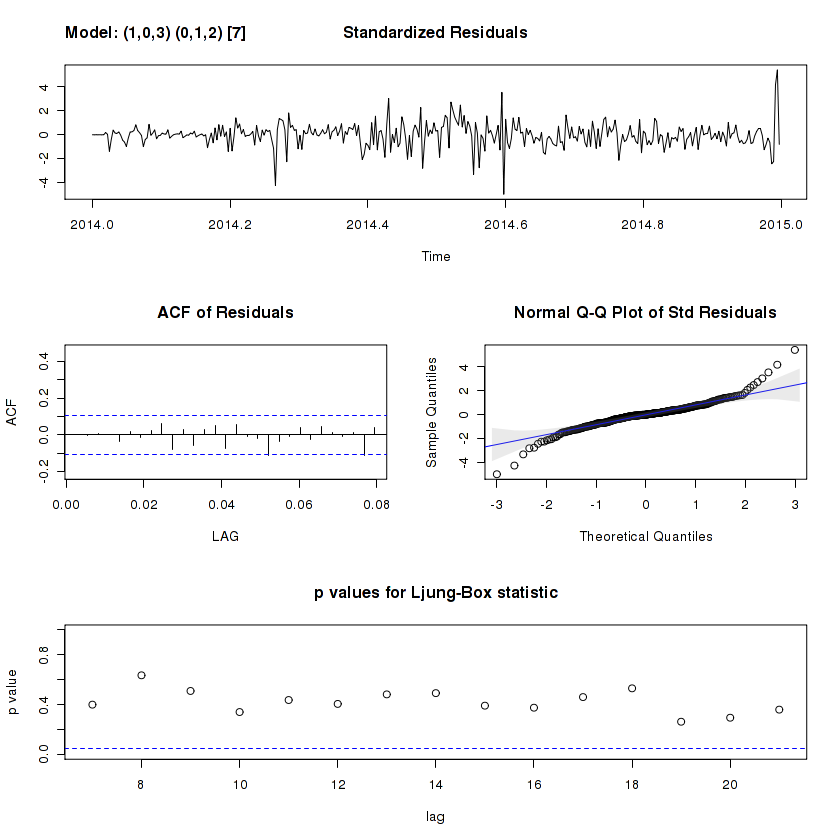

$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = xreg, optim.control = list(trace = trc, REPORT = 1, 
    reltol = tol))

Coefficients:
         ar1      ma1      ma2     sma1    xreg
      0.8628  -0.4810  -0.1627  -0.9043  0.9104
s.e.  0.0696   0.0858   0.0698   0.0408  0.0519

sigma^2 estimated as 25478:  log likelihood = -2329.83,  aic = 4671.66

$degrees_of_freedom
[1] 360

$ttable
     Estimate     SE  t.value p.value
ar1    0.8628 0.0696  12.3919  0.0000
ma1   -0.4810 0.0858  -5.6048  0.0000
ma2   -0.1627 0.0698  -2.3309  0.0203
sma1  -0.9043 0.0408 -22.1659  0.0000
xreg   0.9104 0.0519  17.5546  0.0000

$AIC
[1] 11.17295

$AICc
[1] 11.17907

$BIC
[1] 10.22638


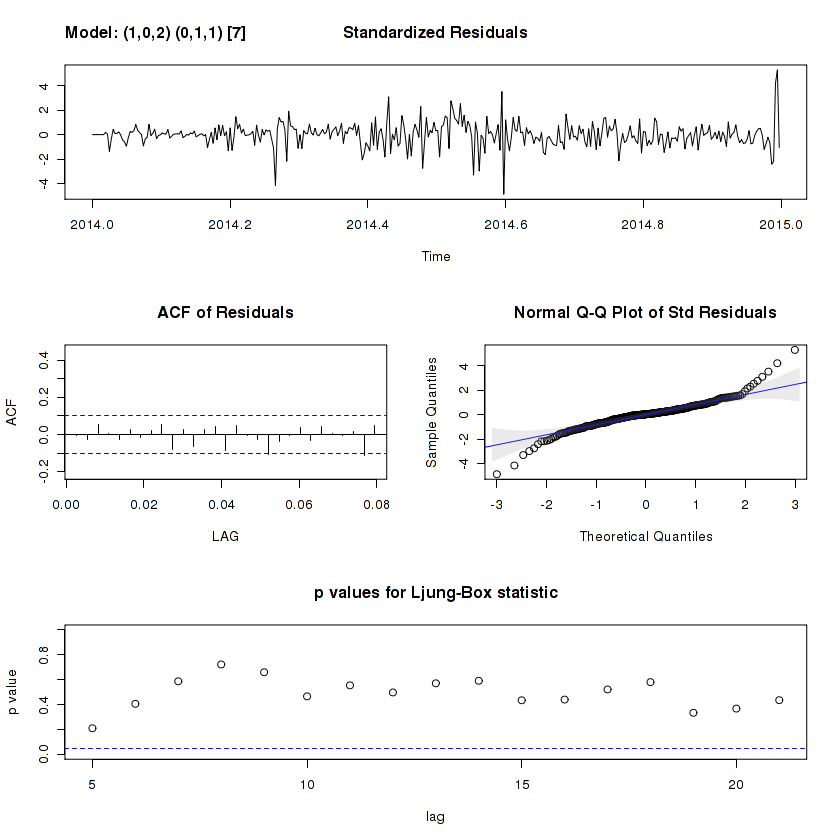

In [25]:
# R LANG::
# [ARIMA(1,0,3(0)) x ARIMA(0,1,2)_{7}]
summary(fitGam1)

# Design Matrix
XReg <- fitGam1$linear.predictors

# Suggested by the ACF/PACF Plots
sarima(rkWh,1,0,3,P=0,D=1,Q=2,S=7, xreg = XReg)
fitGam1_SARIMA1 <- arima(rkWh, order=c(1,0,3), seasonal = list(order=c(0,1,2), period=7), xreg=XReg)
# Suggested by the t-Statistics of the previous model:
sarima(rkWh,1,0,2,P=0,D=1,Q=1,S=7, xreg = XReg)
fitGam1_SARIMA2 <- arima(rkWh, order=c(1,0,2), seasonal = list(order=c(0,1,1), period=7), xreg=XReg)

From the diagnostic diagrams above, and especially the ones that corresponds to the best of our models, $\mathbf{ARIMA(1,0,2)\,\times\,(0,1,1)_{7}}$ **(`fitGam1_SARIMA2`)**, we observe that ***no significant outliers exist*** in ***times series*** (Standardized Residuals timeseries plot), neither ***significant departure from normality*** (Normal Q-Q Plot of Residuals), ***except*** of course during the ***last few days of 2014***. Furthermore, the ACF Plot of Residuals does not reveal any autocorrelation, and the Q-Statistics is never significant at the lags shown, supporting that way the whiteness of the residuals.

#### B. `fitSq1`


Call:
lm(formula = rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq, 
    na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-683.72 -100.53    5.72   83.95 1138.79 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     4.556e+05  7.116e+04   6.402 4.76e-10 ***
rkwh_trend     -2.259e+02  3.532e+01  -6.395 4.96e-10 ***
rtemp_demean    5.895e+01  1.633e+00  36.109  < 2e-16 ***
rtemp_demeanSq  3.811e+00  2.391e-01  15.936  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 191.5 on 361 degrees of freedom
Multiple R-squared:  0.7957,	Adjusted R-squared:  0.794 
F-statistic: 468.8 on 3 and 361 DF,  p-value: < 2.2e-16


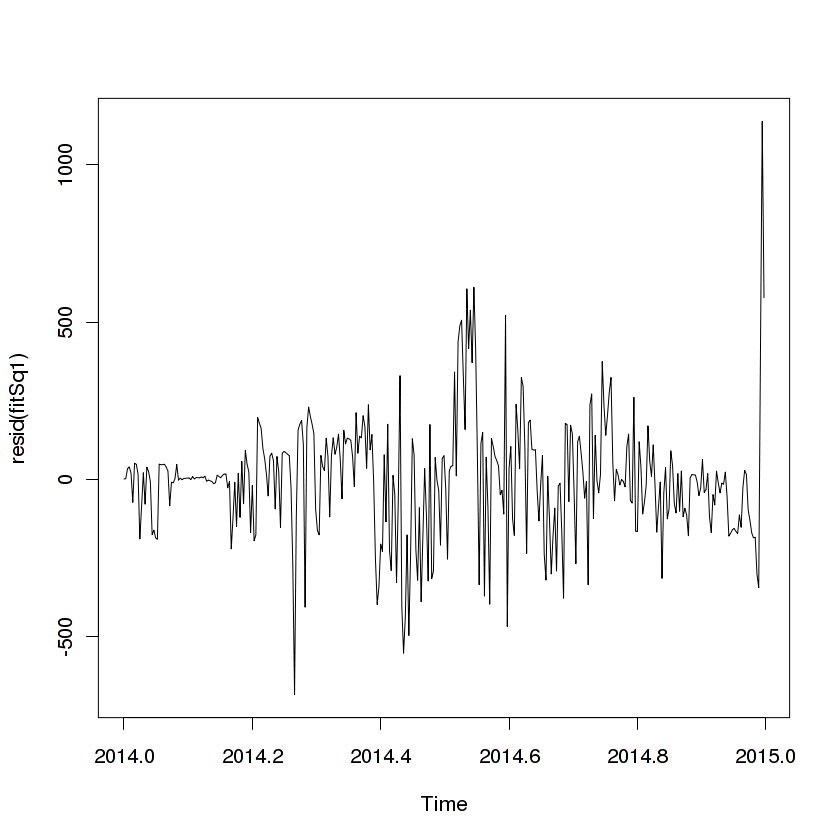

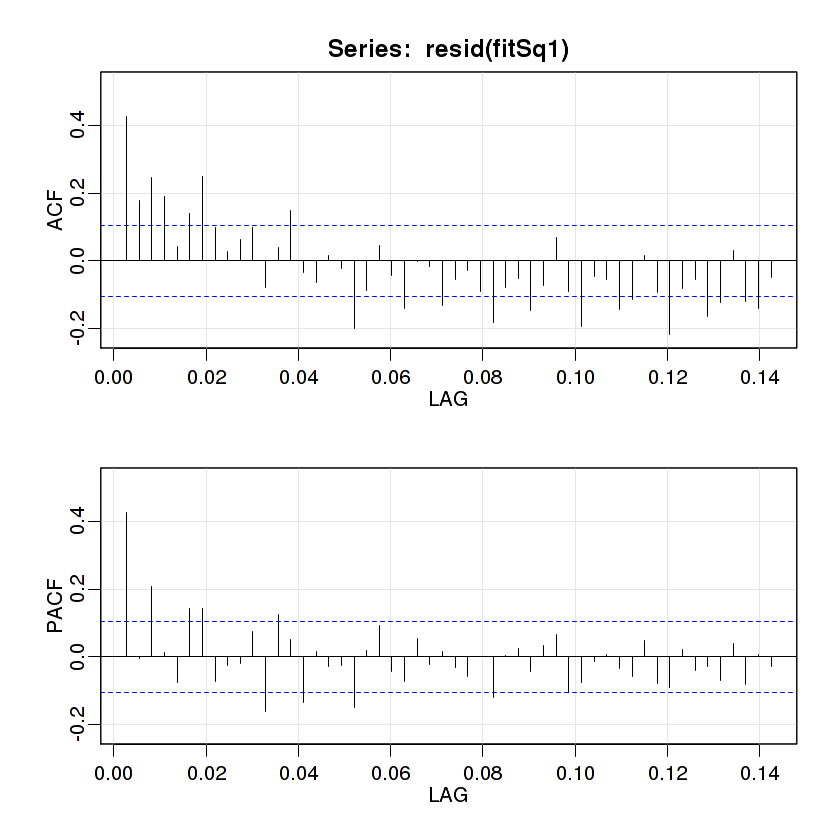

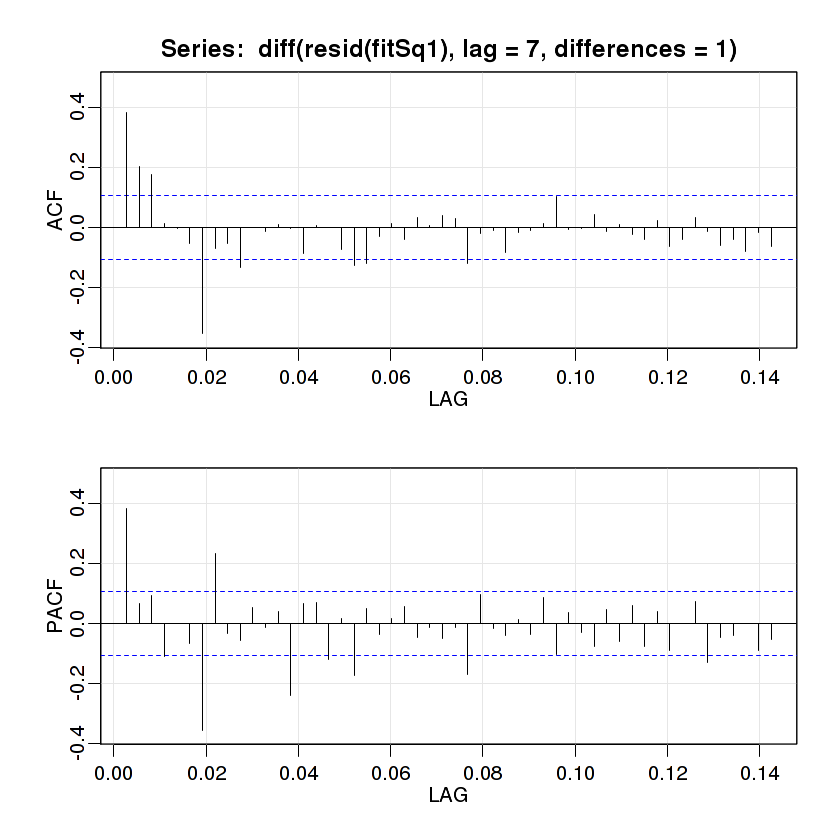

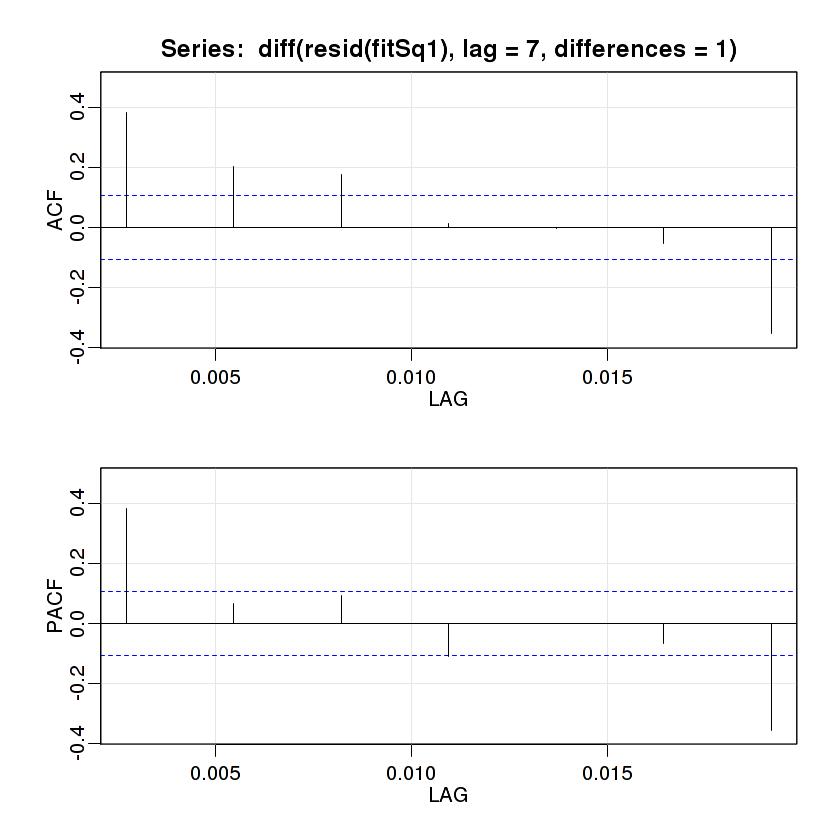

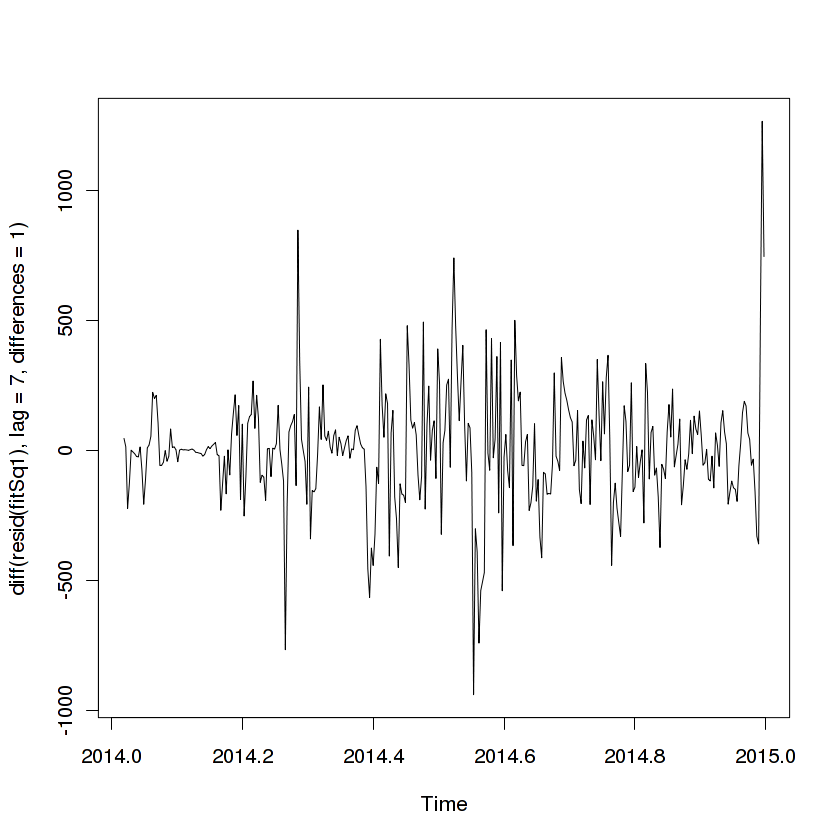

In [26]:
# R LANG::
summary(fitSq1)
plot.ts(resid(fitSq1))
acf <- acf2(resid(fitSq1), max.lag = 52) # Suggests  diff(x,lag=7, differences=1)
acf <- acf2(diff(resid(fitSq1), lag=7, differences = 1), max.lag = 52) # Suggests [ARMA(?,?) x ARMA(0,2)_{7}]
acf <- acf2(diff(resid(fitSq1), lag=7, differences = 1), max.lag = 7) # Suggests [ARMA(1,0(3)) x ARMA(0,2)_{7}]
plot.ts(diff(resid(fitSq1), lag=7, differences = 1))

#### ARIMA Models to Investigate/Fit:  

#### $\mathbf{ARIMA(1,0,3)\,\times\,(0,1,2)_{7}}$ and variations in the non-seasonal `AR` and `MA`  orders

The previous **ACF/PACF plots** suggest that an $\mathbf{ARIMA(1,0,3)\,\times\,(0,1,2)_{7}}$ model will provide a really good fit to our data, probably with some variations in the non-seasonal **AR** and **MA** orders. 

In the few lines of code below we examine this fit, the results we obtain from the **`'arima'` R routine**, as well as slight variations of this model which are suggested by the t-Statistics of its calculated coefficients. We conclude that the $\mathbf{ARIMA(1,0,2)\,\times\,(0,1,1)_{7}}$ model, **`fitSq1_SARIMA2`**, fits our data best. Note that the design matrix which was used during the fitting of the **`fitSq1`** model, 
```
XReg <- cbind(rkwh_trend, rtemp_demean, rtemp_demeanSq),
```
has been plugged-in as a **matrix of external regressors (exogenous variables)**, in the new **ARIMA fits**.


Call:
lm(formula = rkWh ~ rkwh_trend + rtemp_demean + rtemp_demeanSq, 
    na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-683.72 -100.53    5.72   83.95 1138.79 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     4.556e+05  7.116e+04   6.402 4.76e-10 ***
rkwh_trend     -2.259e+02  3.532e+01  -6.395 4.96e-10 ***
rtemp_demean    5.895e+01  1.633e+00  36.109  < 2e-16 ***
rtemp_demeanSq  3.811e+00  2.391e-01  15.936  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 191.5 on 361 degrees of freedom
Multiple R-squared:  0.7957,	Adjusted R-squared:  0.794 
F-statistic: 468.8 on 3 and 361 DF,  p-value: < 2.2e-16


initial  value 5.402133 
iter   2 value 5.388088
iter   3 value 5.235607
iter   4 value 5.111983
iter   5 value 5.100643
iter   6 value 5.085980
iter   7 value 5.076275
iter   8 value 5.075405
iter   9 value 5.073402
iter  10 value 5.072216
iter  11 value 5.071085
iter  12 value 5.070743
iter  13 value 5.070172
iter  14 value 5.069518
iter  15 value 5.068405
iter  16 value 5.067495
iter  17 value 5.066605
iter  18 value 5.066460
iter  19 value 5.066405
iter  20 value 5.066397
iter  20 value 5.066397
final  value 5.066397 
converged
initial  value 5.088935 
iter   2 value 5.088927
iter   3 value 5.088683
iter   4 value 5.088216
iter   5 value 5.087981
iter   6 value 5.087888
iter   7 value 5.087863
iter   8 value 5.087813
iter   9 value 5.087693
iter  10 value 5.087501
iter  11 value 5.087295
iter  12 value 5.087065
iter  13 value 5.086971
iter  14 value 5.086961
iter  15 value 5.086951
iter  16 value 5.086950
iter  17 value 5.086950
iter  17 value 5.086950
iter  17 value 5.086950
final

$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = xreg, optim.control = list(trace = trc, REPORT = 1, 
    reltol = tol))

Coefficients:
         ar1     ma1      ma2     ma3     sma1     sma2  rkwh_trend
      0.8339  -0.390  -0.1369  0.0358  -0.8912  -0.0409   -167.4647
s.e.  0.1230   0.131   0.0901  0.0714   0.0631   0.0663    132.0291
      rtemp_demean  rtemp_demeanSq
           52.9883          3.6627
s.e.        4.3904          0.3478

sigma^2 estimated as 25219:  log likelihood = -2329.11,  aic = 4678.22

$degrees_of_freedom
[1] 356

$ttable
                Estimate       SE  t.value p.value
ar1               0.8339   0.1230   6.7792  0.0000
ma1              -0.3900   0.1310  -2.9771  0.0031
ma2              -0.1369   0.0901  -1.5191  0.1296
ma3               0.0358   0.0714   0.5021  0.6159
sma1             -0.8912   0.0631 -14.1272  0.0000
sma2             -0.0409   0.0663  -0.6172  0.5375
rkwh_trend     -167.

initial  value 5.402133 
iter   2 value 5.389260
iter   3 value 5.248305
iter   4 value 5.132094
iter   5 value 5.110965
iter   6 value 5.103058
iter   7 value 5.099024
iter   8 value 5.096776
iter   9 value 5.093940
iter  10 value 5.092971
iter  11 value 5.089939
iter  12 value 5.088342
iter  13 value 5.085861
iter  14 value 5.084268
iter  15 value 5.076590
iter  16 value 5.072882
iter  17 value 5.072533
iter  18 value 5.071713
iter  19 value 5.070514
iter  20 value 5.070031
iter  21 value 5.069891
iter  22 value 5.069780
iter  23 value 5.069724
iter  24 value 5.069716
iter  25 value 5.069707
iter  26 value 5.069706
iter  27 value 5.069706
iter  27 value 5.069706
iter  27 value 5.069706
final  value 5.069706 
converged
initial  value 5.090156 
iter   2 value 5.090051
iter   3 value 5.088851
iter   4 value 5.088119
iter   5 value 5.087847
iter   6 value 5.087818
iter   7 value 5.087797
iter   8 value 5.087784
iter   9 value 5.087774
iter  10 value 5.087764
iter  11 value 5.087754
iter 

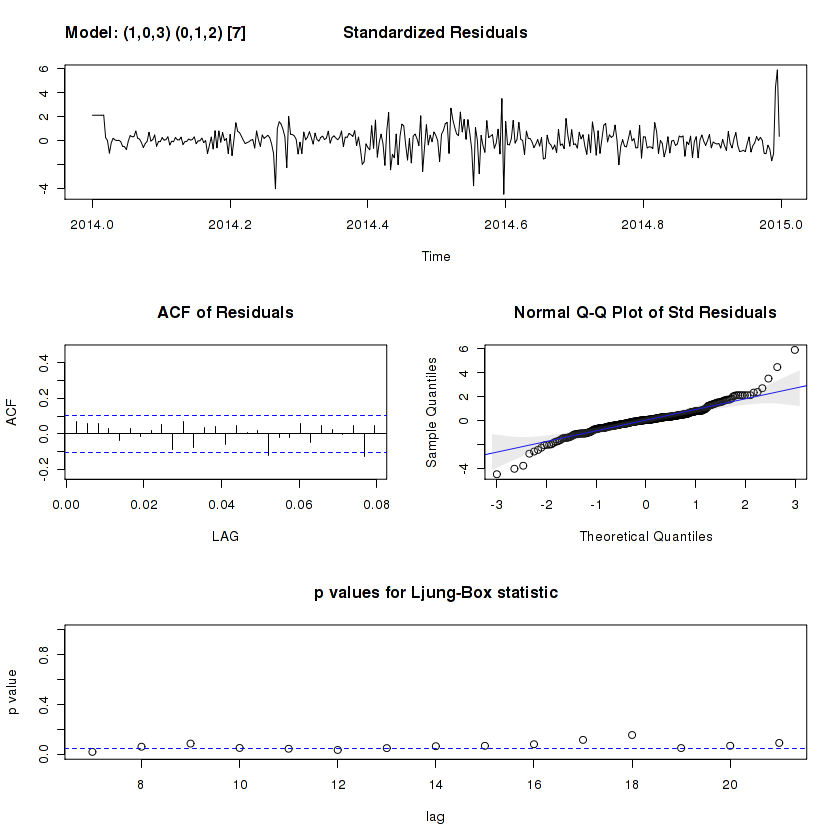

$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = xreg, optim.control = list(trace = trc, REPORT = 1, 
    reltol = tol))

Coefficients:
         ar1      ma1      ma2     sma1  rkwh_trend  rtemp_demean
      0.8772  -0.4294  -0.1508  -0.9197   -162.1466       51.8974
s.e.  0.0630   0.0824   0.0727   0.0420    158.2603        4.3100
      rtemp_demeanSq
              3.6580
s.e.          0.3527

sigma^2 estimated as 25335:  log likelihood = -2329.39,  aic = 4674.78

$degrees_of_freedom
[1] 358

$ttable
                Estimate       SE  t.value p.value
ar1               0.8772   0.0630  13.9282  0.0000
ma1              -0.4294   0.0824  -5.2086  0.0000
ma2              -0.1508   0.0727  -2.0750  0.0387
sma1             -0.9197   0.0420 -21.9228  0.0000
rkwh_trend     -162.1466 158.2603  -1.0246  0.3063
rtemp_demean     51.8974   4.3100  12.0413  0.0000
rtemp_demeanSq    3.6580   0.3527  10.3709  0.0000

$AIC
[1] 11.1782

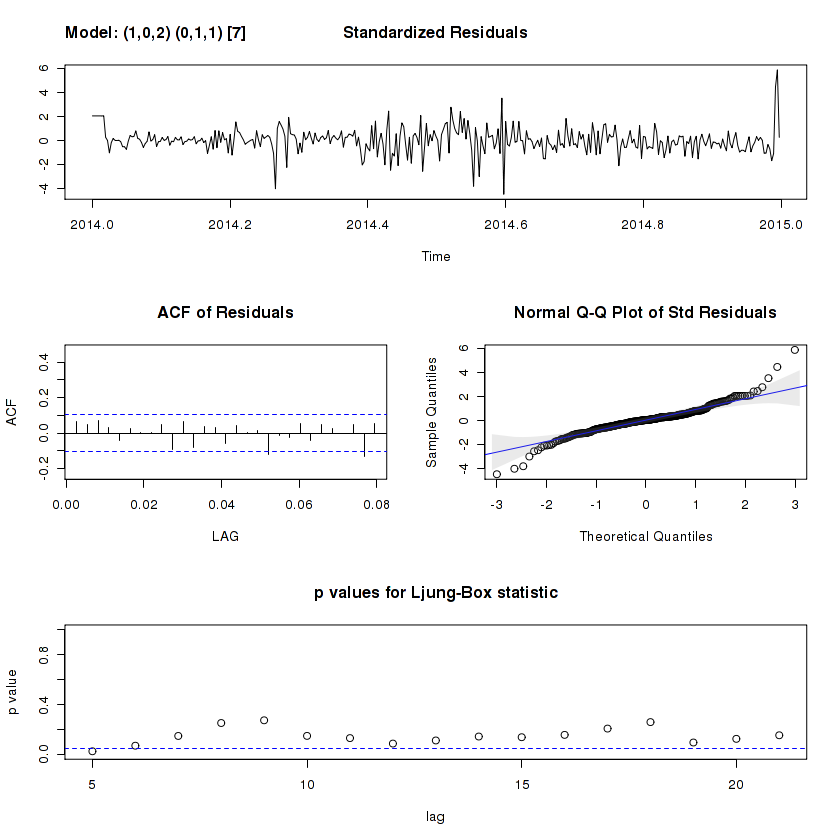

In [27]:
# R LANG::
# [ARIMA(1,0,0(3)) x ARIMA(0,1,2)_{7}]
summary(fitSq1)

# Design Matrix
XReg <- cbind(rkwh_trend, rtemp_demean, rtemp_demeanSq)

# Suggested by the ACF/PACF Plots
sarima(rkWh,1,0,3,P=0,D=1,Q=2,S=7, xreg = XReg)
fitSq1_SARIMA1 <- arima(rkWh, order=c(1,0,3), seasonal = list(order=c(0,1,2), period=7), xreg=XReg)
# Suggested by the t-Statistics of the previous model:
sarima(rkWh,1,0,2,P=0,D=1,Q=1,S=7, xreg = XReg)
fitSq1_SARIMA2 <- arima(rkWh, order=c(1,0,2), seasonal = list(order=c(0,1,1), period=7), xreg=XReg)

From the diagnostic diagrams above, and especially the ones that corresponds to the best of our models, $\mathbf{ARIMA(1,0,2)\,\times\,(0,1,1)_{7}}$ **(`fitSq1_SARIMA2`)**, we observe that ***no significant outliers exist*** in ***times series*** (Standardized Residuals timeseries plot), neither ***significant departure from normality*** (Normal Q-Q Plot of Residuals), ***except*** of course during the ***early few days of 2014*** and the ***last ones of the same year***. Furthermore, the ACF Plot of Residuals does not reveal any autocorrelation, and the Q-Statistics is never significant at the lags shown, supporting that way the whiteness of the residuals.

#### C. Model Comparison: `fitGam1_SARIMA2` vs `fitSq1_SARIMA2` 

'fitGam1_SARIMA2' Model:



Call:
arima(x = rkWh, order = c(1, 0, 2), seasonal = list(order = c(0, 1, 1), period = 7), 
    xreg = XReg)

Coefficients:
         ar1      ma1      ma2     sma1    XReg
      0.8628  -0.4810  -0.1627  -0.9043  0.9104
s.e.  0.0696   0.0858   0.0698   0.0408  0.0519

sigma^2 estimated as 25478:  log likelihood = -2329.83,  aic = 4671.66

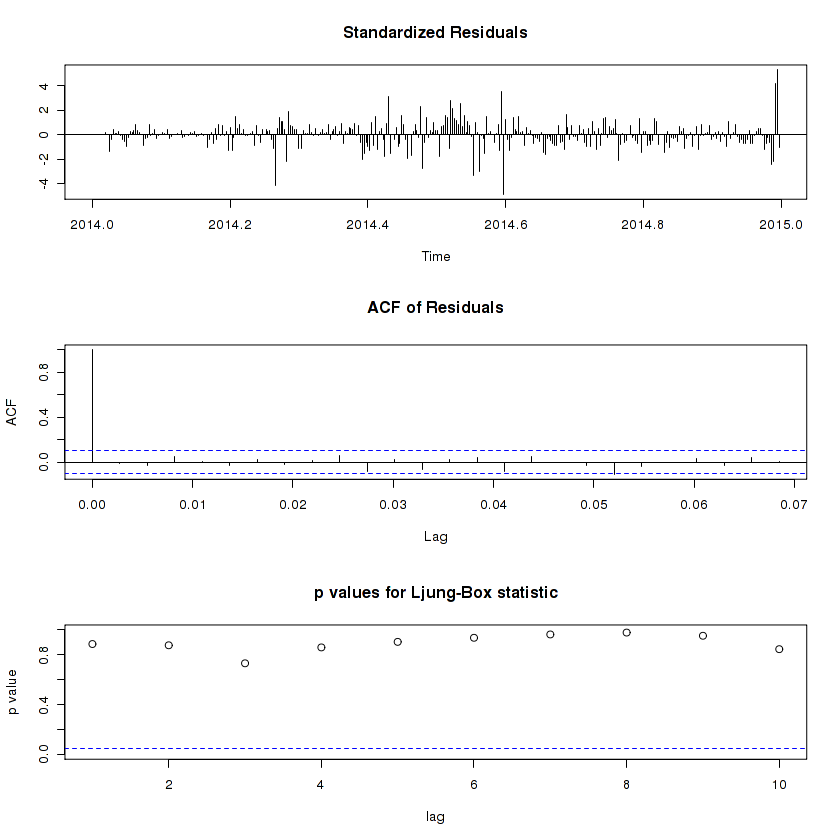

In [28]:
# R LANG::
# fitGam1_SARIMA2
writeLines('\'fitGam1_SARIMA2\' Model:')
fitGam1_SARIMA2
tsdiag(fitGam1_SARIMA2)

'fitSq1_SARIMA2' Model:



Call:
arima(x = rkWh, order = c(1, 0, 2), seasonal = list(order = c(0, 1, 1), period = 7), 
    xreg = XReg)

Coefficients:
         ar1      ma1      ma2     sma1  rkwh_trend  rtemp_demean
      0.8772  -0.4294  -0.1508  -0.9197   -162.1466       51.8974
s.e.  0.0630   0.0824   0.0727   0.0420    158.2603        4.3100
      rtemp_demeanSq
              3.6580
s.e.          0.3527

sigma^2 estimated as 25335:  log likelihood = -2329.39,  aic = 4674.78

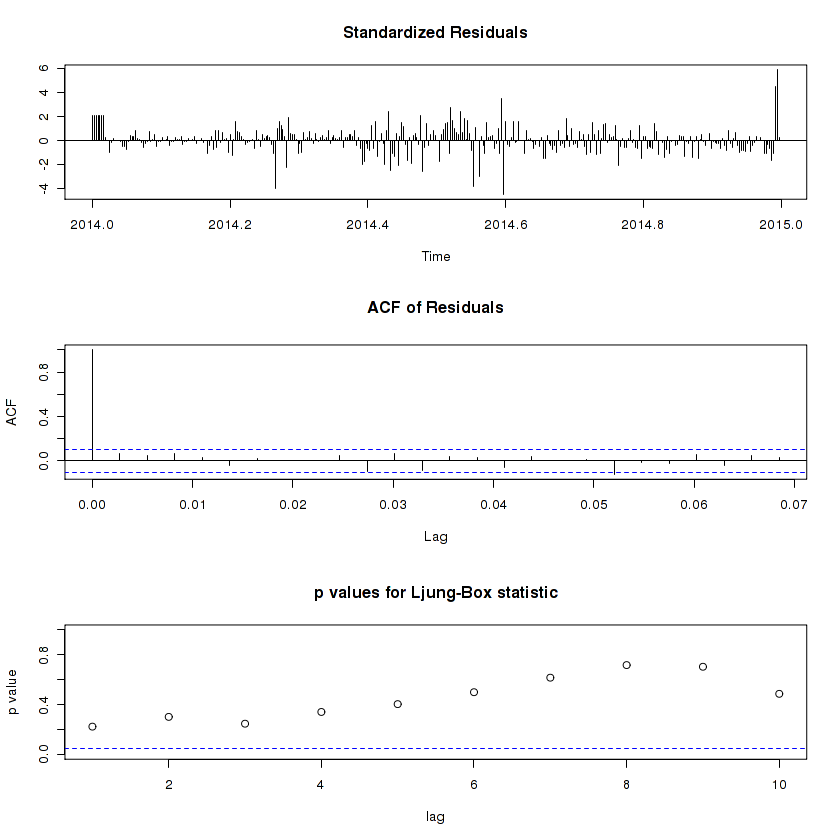

In [29]:
# R LANG::
# fitSq1_SARIMA2
writeLines('\'fitSq1_SARIMA2\' Model:')
fitSq1_SARIMA2
tsdiag(fitSq1_SARIMA2)

In [30]:
AIC(fitGam1_SARIMA2, fitSq1_SARIMA2)
BIC(fitGam1_SARIMA2, fitSq1_SARIMA2)

,df,AIC
fitGam1_SARIMA2,6,4671.660
fitSq1_SARIMA2,8,4674.778


,df,BIC
fitGam1_SARIMA2,6,4694.943
fitSq1_SARIMA2,8,4705.822


From the **diagnostics diagrams** above and the **Statistics Information Criteria, `AIC`/`BIC`**, we can easily verify  that the **`fitGam1_SARIMA2`** model is supperior over the other, simpler one, **`fitSq1_SARIMA2`**.

In the next section, we are going to use the **`fitGam1_SARIMA2`** model to provide short and long-term forecasts. The results are indeed great!

## 5. Energy Consumption Forecast (`'kWh'`):

Finally, we provide an **Energy Consumption Forecast (`'kWh'`)** based on this last model, **`fitGam1_SARIMA2`**, for the next 60 and 90 calendar days and for a long-term period. Note that our model have great predictive performance both for short and long-term time forecasts.

### Short-term Forecast: next 60 & 90 calendar days

Warning message in z[[1L]] + xm:
“longer object length is not a multiple of shorter object length”Warning message in z[[1L]] + xm:
“longer object length is not a multiple of shorter object length”Warning message:
“Removed 60 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 90 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”

null device 
          1

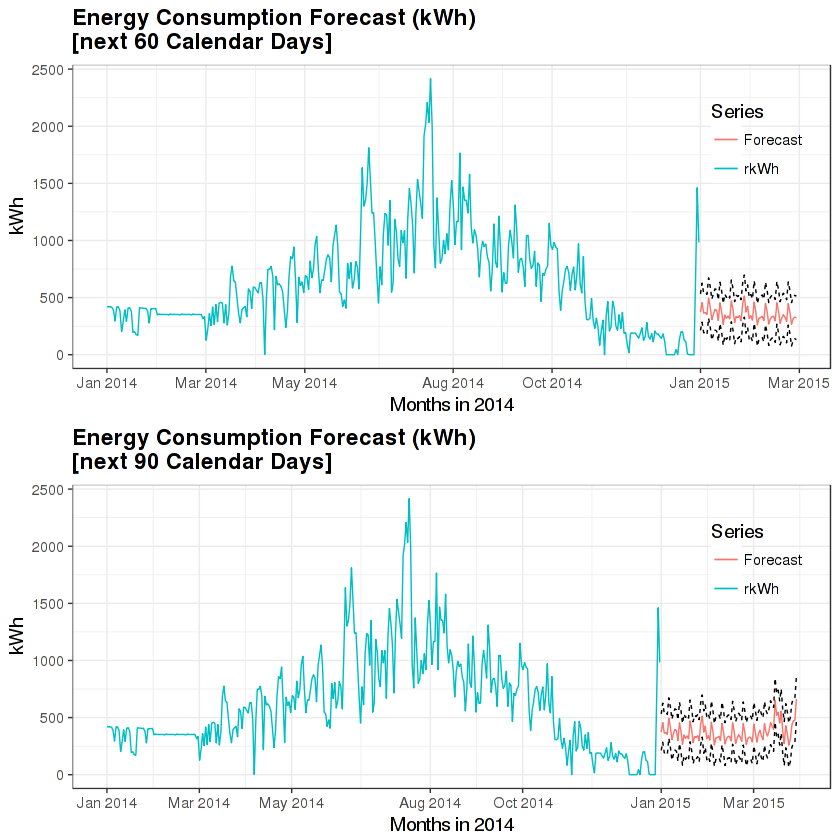

In [31]:
# R LANG::
# Design Matrix
XReg <- fitGam1$linear.predictors

# Energy Consumption Forecasts for the next 60 and 90 calendar days
grid.newpage()
pushViewport(viewport(layout = grid.layout(2,1, widths=unit(1,'npc'), heights=unit(1/2,'npc'))))

# Next 60 Days
nAhead = 60
fore <- predict(fitGam1_SARIMA2, n.ahead = nAhead, newxreg = XReg, prediction.interval = TRUE)
# DataFrame of Actual and Predicted Energy Consumption (kWh)
predDF <- data.frame(cbind(date=c(index(rkWh),index(fore$pred)[1: nAhead]),
                           rkwh=c(melt(rkWh)$value, rep(NA,nAhead)),
                           pred=c(rep(NA,length(index(rkWh))), melt(fore$pred)$value[1: nAhead]),
                           se=c(rep(NA, length(index(rkWh))), melt(fore$se)$value[1: nAhead])))
fig1 <- (ggplot(predDF, aes(date)) +
             geom_line(aes(y=rkwh, colour='rkWh')) +
             geom_line(aes(y=pred, colour='Forecast'), linetype='solid') +
             geom_line(aes(y=pred+se), linetype='dashed') +
             geom_line(aes(y=pred-se), linetype='dashed') +
             theme(legend.position = c(0.9,0.9), legend.justification=c(0.5, 1),
                   legend.background = element_blank()) +
             labs(title='Energy Consumption Forecast (kWh)\n[next 60 Calendar Days]', 
                  x='Months in 2014', y='kWh', colour='Series') +
             scale_x_yearmon())

# Next 90 Days
nAhead = 90
fore <- predict(fitGam1_SARIMA2, n.ahead = nAhead, newxreg = XReg, prediction.interval = TRUE)
# DataFrame of Actual and Predicted Energy Consumption (kWh)
predDF <- data.frame(cbind(date=c(index(rkWh),index(fore$pred)[1: nAhead]),
                           rkwh=c(melt(rkWh)$value, rep(NA, nAhead)),
                           pred=c(rep(NA,length(index(rkWh))), melt(fore$pred)$value[1: nAhead]),
                           se=c(rep(NA, length(index(rkWh))), melt(fore$se)$value[1: nAhead])))
fig2 <- (ggplot(predDF, aes(date)) +
             geom_line(aes(y=rkwh, colour='rkWh')) + 
             geom_line(aes(y=pred, colour='Forecast'), linetype='solid') +
             geom_line(aes(y=pred+se), linetype='dashed') +
             geom_line(aes(y=pred-se), linetype='dashed') +
             theme(legend.position = c(0.9,0.9), legend.justification=c(0.5, 1),
                   legend.background = element_blank()) +
             labs(title='Energy Consumption Forecast (kWh)\n[next 90 Calendar Days]', 
                  x='Months in 2014', y='kWh', colour='Series') +
             scale_x_yearmon())

# Print the plots in the pre-defined Viewport
print(fig1, vp=viewport(layout.pos.row = 1, layout.pos.col = 1))
print(fig2, vp=viewport(layout.pos.row = 2, layout.pos.col = 1))
dev.off()

### Long-term Forecast: next semester & next year

Warning message in z[[1L]] + xm:
“longer object length is not a multiple of shorter object length”Warning message in z[[1L]] + xm:
“longer object length is not a multiple of shorter object length”Warning message:
“Removed 183 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 396 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (geom_path).”Warning message:
“Removed 365 rows containing missing values (ge

null device 
          1

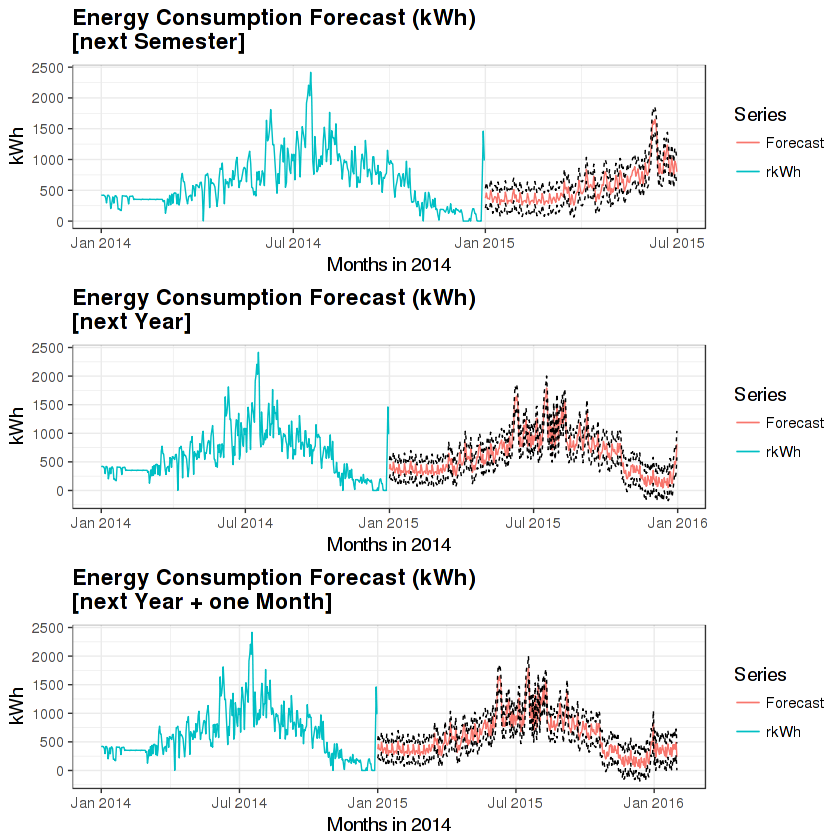

In [32]:
# R LANG::
# Design Matrix
XReg <- fitGam1$linear.predictors

# Energy Consumption Forecasts for the next 60 and 90 calendar days
grid.newpage()
pushViewport(viewport(layout = grid.layout(3,1, widths=unit(1,'npc'), heights=unit(1/3,'npc'))))

# Next Semester
nAhead = 183
fore <- predict(fitGam1_SARIMA2, n.ahead = nAhead, newxreg = XReg, prediction.interval = TRUE)
# DataFrame of Actual and Predicted Energy Consumption (kWh)
predDF <- data.frame(cbind(date=c(index(rkWh),index(fore$pred)[1: nAhead]),
                           rkwh=c(melt(rkWh)$value, rep(NA, nAhead)),
                           pred=c(rep(NA,length(index(rkWh))), melt(fore$pred)$value[1: nAhead]),
                           se=c(rep(NA, length(index(rkWh))), melt(fore$se)$value[1: nAhead])))
fig1 <- (ggplot(predDF, aes(date)) +
             geom_line(aes(y=rkwh, colour='rkWh')) +
             geom_line(aes(y=pred, colour='Forecast'), linetype='solid') +
             geom_line(aes(y=pred+se), linetype='dashed') +
             geom_line(aes(y=pred-se), linetype='dashed') +
             #theme(legend.position = c(0.9,0.9), legend.justification=c(0.5, 1), 
             #      legend.background = element_blank()) +
             labs(title='Energy Consumption Forecast (kWh)\n[next Semester]', 
                  x='Months in 2014', y='kWh', colour='Series') +
             scale_x_yearmon())

# Next Year
nAhead = 365
fore <- predict(fitGam1_SARIMA2, n.ahead = nAhead, newxreg = XReg, prediction.interval = TRUE)
# DataFrame of Actual and Predicted Energy Consumption (kWh)
predDF <- data.frame(cbind(date=c(index(rkWh),index(fore$pred)[1: nAhead]),
                           rkwh=c(melt(rkWh)$value, rep(NA, nAhead)),
                           pred=c(rep(NA,length(index(rkWh))), melt(fore$pred)$value[1: nAhead]),
                           se=c(rep(NA, length(index(rkWh))), melt(fore$se)$value[1: nAhead])))
fig2 <- (ggplot(predDF, aes(date)) +
             geom_line(aes(y=rkwh, colour='rkWh')) +
             geom_line(aes(y=pred, colour='Forecast'), linetype='solid') +
             geom_line(aes(y=pred+se), linetype='dashed') +
             geom_line(aes(y=pred-se), linetype='dashed') +
             #theme(legend.position = c(0.9,0.9), legend.justification=c(0.5, 1),
             #      legend.background=element_blank()) +
             labs(title='Energy Consumption Forecast (kWh)\n[next Year]', 
                  x='Months in 2014', y='kWh', colour='Series') +
             scale_x_yearmon())

# Next Year + One Month
nAhead = 365 + 31
fore <- predict(fitGam1_SARIMA2, n.ahead = nAhead, newxreg = XReg, prediction.interval = TRUE)
# DataFrame of Actual and Predicted Energy Consumption (kWh)
predDF <- data.frame(cbind(date=c(index(rkWh),index(fore$pred)[1: nAhead]),
                           rkwh=c(melt(rkWh)$value, rep(NA, nAhead)),
                           pred=c(rep(NA,length(index(rkWh))), melt(fore$pred)$value[1: nAhead]),
                           se=c(rep(NA, length(index(rkWh))), melt(fore$se)$value[1: nAhead])))
fig3 <- (ggplot(predDF, aes(date)) +
             geom_line(aes(y=rkwh, colour='rkWh')) +
             geom_line(aes(y=pred, colour='Forecast'), linetype='solid') +
             geom_line(aes(y=pred+se), linetype='dashed') +
             geom_line(aes(y=pred-se), linetype='dashed') +
             #theme(legend.position = c(0.9,0.9), legend.justification=c(0.5, 1), 
             #      legend.background=element_blank()) +
             labs(title='Energy Consumption Forecast (kWh)\n[next Year + one Month]', 
                  x='Months in 2014', y='kWh', colour='Series') +
             scale_x_yearmon())

# Print the plots in the pre-defined Viewport
print(fig1, vp=viewport(layout.pos.row = 1, layout.pos.col = 1))
print(fig2, vp=viewport(layout.pos.row = 2, layout.pos.col = 1))
print(fig3, vp=viewport(layout.pos.row = 3, layout.pos.col = 1))
dev.off()

## 6. Conclusion / Remarks

The regression model with autocorrelated errors we fit previously, namely **`fitGam1_SARIMA2`**, can provide ***accurate short*** and ***long-term forecasts***.

More specifically, the simulated time series of energy consumption which is returned by the model is surprisingly similar with the one provided, except of course some peaks during the hot summer days and the New Year's Eve. At these times the forecasted consumption is significantly lower than the one had during the same periods in 2014. The reason for this deficiency is two-fold. First, the **`'Temp'`** timeseries and its contribution in the energy consumption can be better accomodated by a better initial regression model. Secondly, the specific energy consumption peak around New Year's Eve, was treated as an outlier by our model. Having historical data of two and more years would allow us to better incorporate these seasonalities in our model and hopefully provide even better predictions.

As a final remark, I expect that this kind of timeseries (**`'kWh'`**) and its dependence from quantitative (**`'Temp'`**) or categorical variables (**`'Traffic'`**) can be also studied by utilizing other time domain methods or state-space practices.